# **453 Individual Assignment - End-to-End ML Project**
## **Customer Churn Prediction Machine Learning Model**
### Shaolong (Fred) Xue

### **Introduction**

For this assignment, we're predicting customer churn rate for a bank. The data is provided by the instructor, coming from here: https://www.kaggle.com/code/linastianbao/bank-churn-prediction/input

In this coding part, we will do some EDA and data preprocessing to set up for modeling. Then we will build classification models to predict customer churn. We will conclude with model performance evualation, selection, and a final summary. 

### **Data Preview**

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, precision_recall_curve, auc

In [2]:
data = pd.read_csv("Churn_Modelling.csv")

In [3]:
data.shape # a dataframe of 10000 rows and 14 columns

(10000, 14)

In [4]:
# check columns and missing values
data.isnull().sum() # no NAs in the data

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [5]:
# check number of unique values in each column
data.nunique() 

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

In [6]:
# RowNumber and CustomerId are unique to each customer. we can drop them, as well as Surname. 
# They are no use for churn prediction.  
data = data.drop(["RowNumber", "CustomerId", "Surname"], axis = 1)

In [7]:
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [8]:
# check column variable types
data.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

### **EDA**

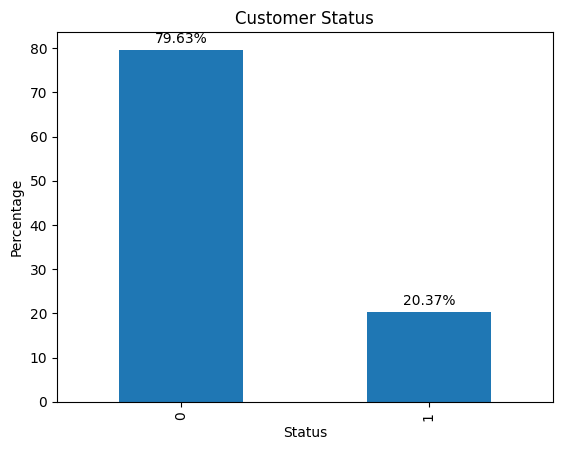

In [9]:
def plot_customer_status(data):
    # Calculate the number of customers who exited and who are still active
    status_counts = data['Exited'].value_counts()

    # Calculate the percentage of customers who exited and who are still active
    status_percentages = status_counts / len(data) * 100

    # Create a bar plot
    ax = status_percentages.plot.bar()

    # Add percentage labels to each bar
    for rect in ax.patches:
        height = rect.get_height()
        ax.annotate(f'{round(height, 2)}%', xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

    # Set the plot title and axis labels
    plt.title("Customer Status")
    plt.xlabel("Status")
    plt.ylabel("Percentage")

    # Show the plot
    plt.show()

# Call the function to plot the customer status
plot_customer_status(data)

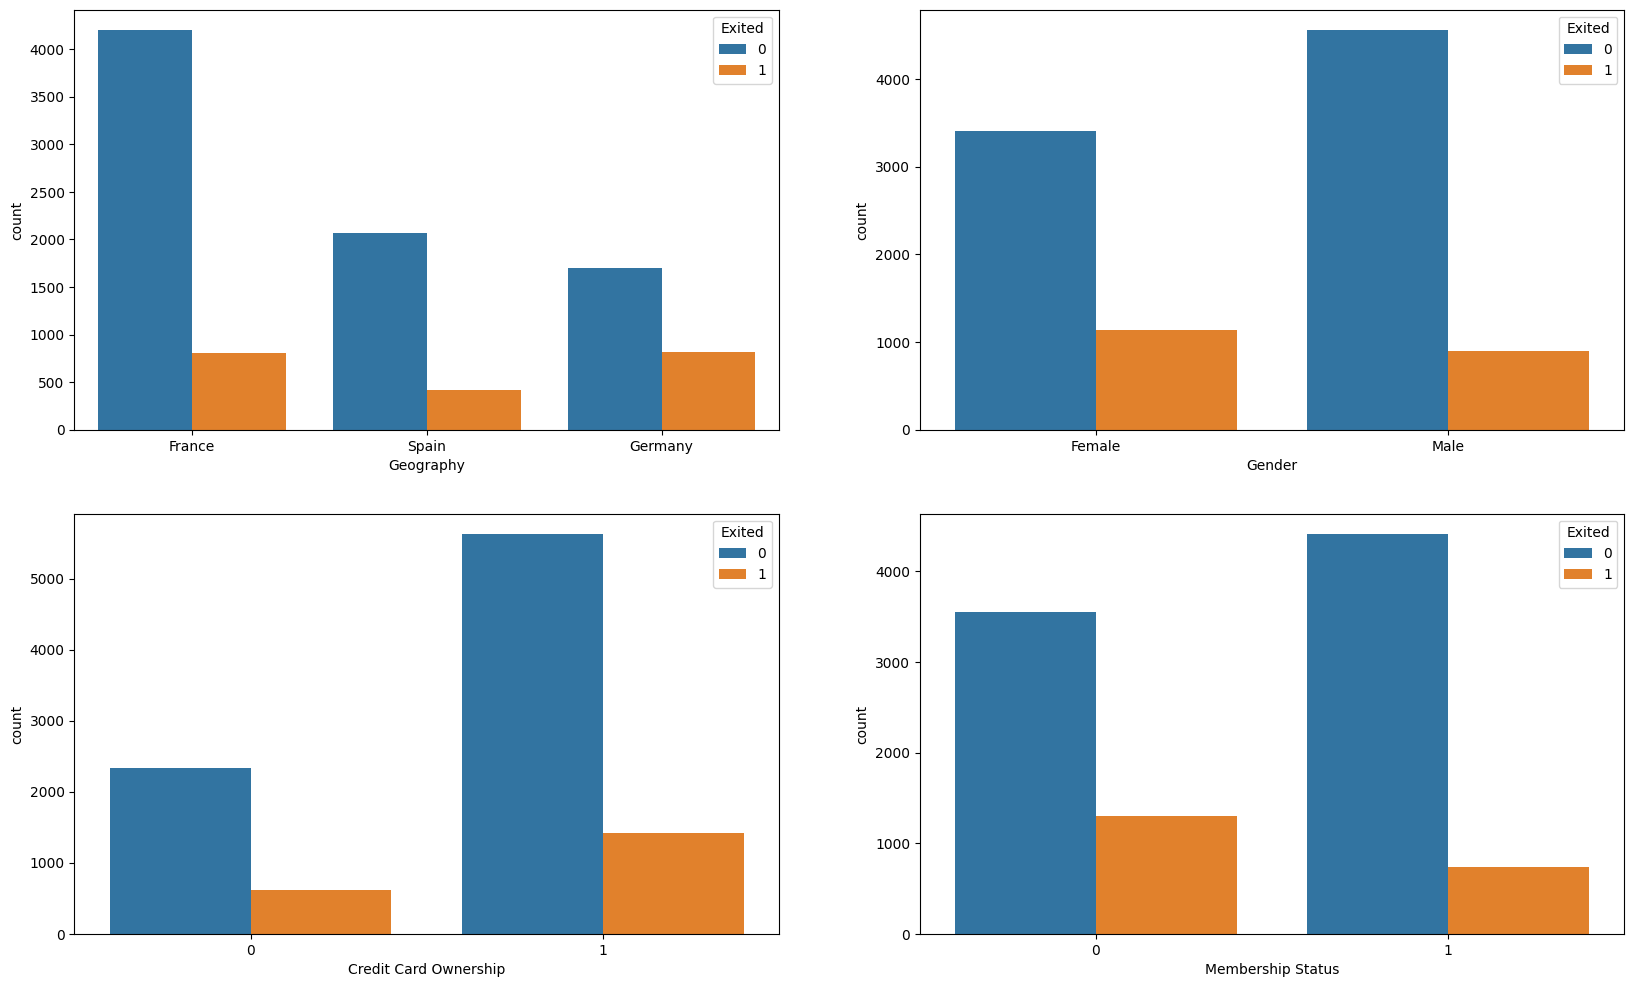

In [10]:
def plot_churn_vs_categorical(data):
    # Create a dictionary of categorical variables and their labels
    categorical_vars = {
        'Geography': 'Geography',
        'Gender': 'Gender',
        'HasCrCard': 'Credit Card Ownership',
        'IsActiveMember': 'Membership Status'
    }

    # Create a 2x2 grid of subplots
    fig, axarr = plt.subplots(2, 2, figsize=(20, 12))

    # Iterate through the categorical variables and create count plots
    for idx, (var, label) in enumerate(categorical_vars.items()):
        row, col = divmod(idx, 2)
        sns.countplot(x=var, hue='Exited', data=data, ax=axarr[row][col])
        axarr[row][col].set_xlabel(label)

# Call the function to plot customer churn status vs categorical variables
plot_churn_vs_categorical(data)

Based on the data: 
* Customers in Germany are more likely to churn comparing to customers in France and Spain. 
* Female customers are more likely to churn comparing to male customers
* Creditcard ownership doesn't have apparently association with churn
* Active members are less likely to churn than non-active members

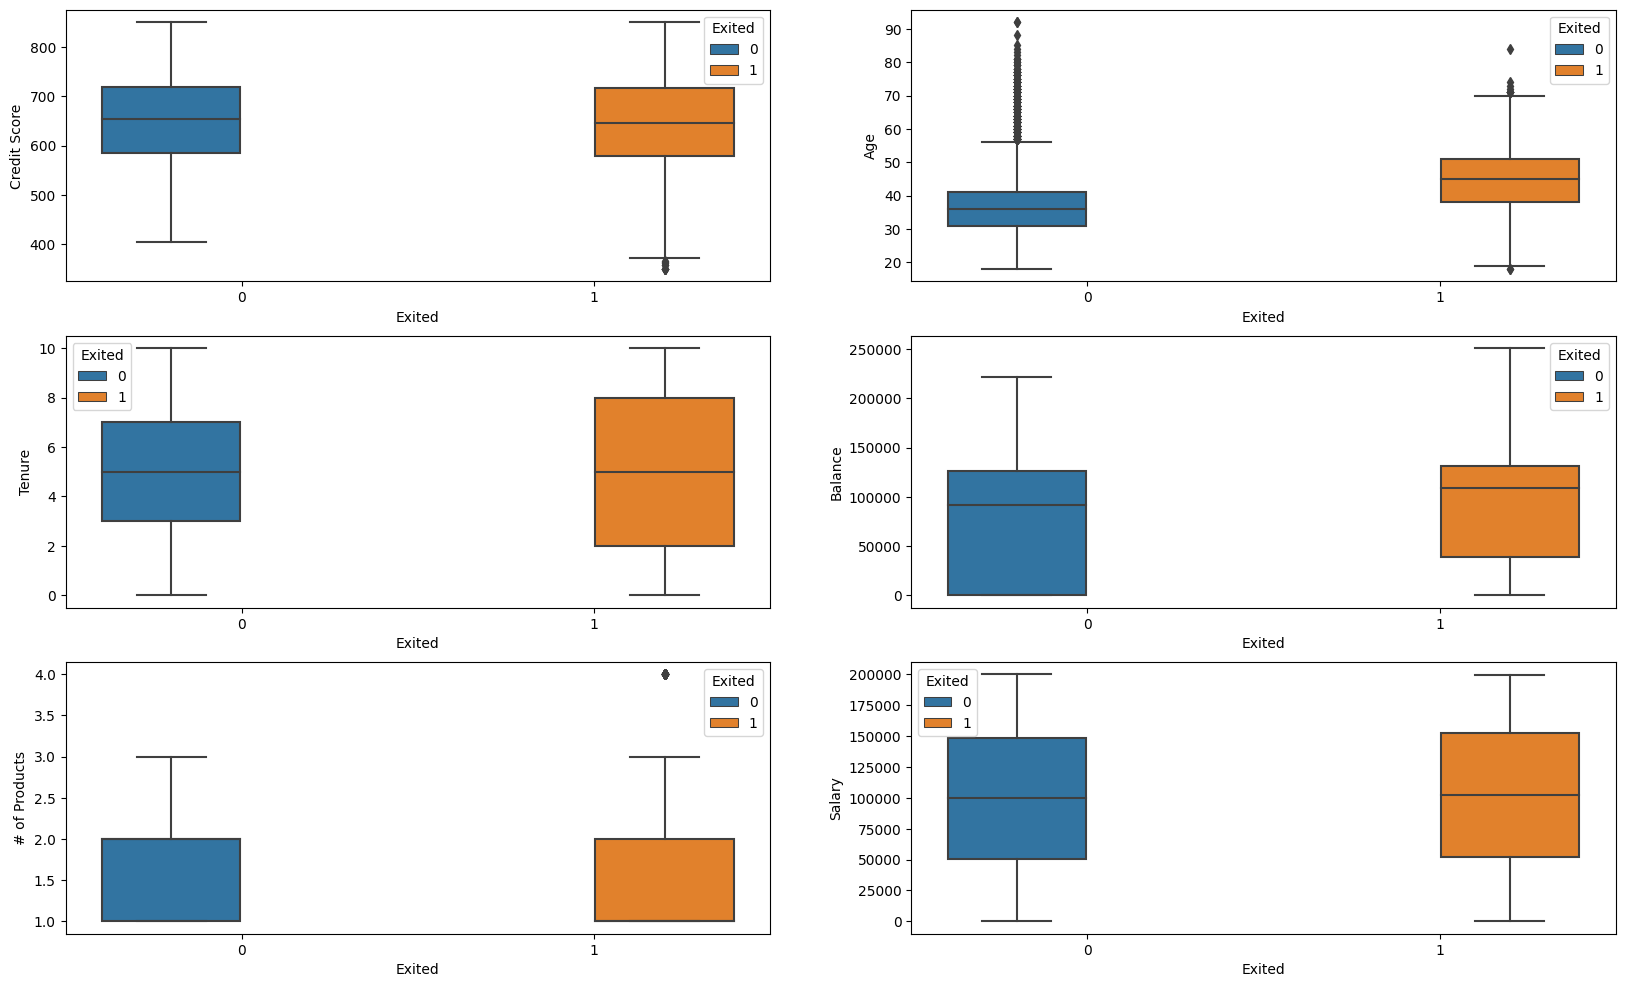

In [11]:
def plot_churn_vs_continuous(data):
    # Create a list of continuous variables and their labels
    continuous_vars = [
        ('CreditScore', 'Credit Score'),
        ('Age', 'Age'),
        ('Tenure', 'Tenure'),
        ('Balance', 'Balance'),
        ('NumOfProducts', '# of Products'),
        ('EstimatedSalary', 'Salary')
    ]

    # Create a 3x2 grid of subplots
    fig, axarr = plt.subplots(3, 2, figsize=(20, 12))

    # Iterate through the continuous variables and create box plots
    for idx, (var, label) in enumerate(continuous_vars):
        row, col = divmod(idx, 2)
        sns.boxplot(y=var, x='Exited', hue='Exited', data=data, ax=axarr[row][col])
        axarr[row][col].set_xlabel('Exited')
        axarr[row][col].set_ylabel(label)

# Call the function to plot customer churn status vs continuous variables
plot_churn_vs_continuous(data)

Based on the data:
* Older customers seem to be more likely to churn than younger customers
* Churned customers seem to have higher balances on average than customers who are current with the bank.
* Other continuous variables do not show obviously apparent trends regarding churning. 

### **Preprocessing**

Based on the readings provided from McKinsey and HBR:
* https://www.mckinsey.com/industries/technology-media-and-telecommunications/our-insights/reducing-churn-in-telecom-through-advanced-analytics
* https://hbr.org/2022/12/in-a-downturn-focus-on-existing-customers-not-potential-ones

We want to construct three new variables to address some colinearity issues between a few continuous variables:
1. **Balance by Salary**: Intuitively, having higher balance is more indicative of churning if the salary is lower. So we want to capture this fact instead of looking at balance and salary individually. 
2. **Tenure by Age**: Naturally, tenure is positive associated with age. So we want to capture the factor of tenure given age. 
3. **Credit Score by Age**: Again, credit score naturally develops with age in general. So we need to capture this as well. 


In [12]:
# balance by salary
data["BalanceBySalary"] = data.Balance / data.EstimatedSalary
# tenure by age
data["TenureByAge"] = data.Tenure / data.Age
# credit score by age
data["CreditScoreByAge"] = data.CreditScore / data.Age

In [13]:
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceBySalary,TenureByAge,CreditScoreByAge
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,0.000000,0.047619,14.738095
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0.744677,0.024390,14.829268
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1.401375,0.190476,11.952381
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0.000000,0.025641,17.923077
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,1.587055,0.046512,19.767442


In [14]:
# train test split
y = data["Exited"]
X = data.drop(["Exited"], axis=1)

X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, stratify=y, random_state=100)

In [15]:
# standardization
scaler = StandardScaler()
scaler.fit(X_train[:])
X_train[:] = scaler.transform(X_train[:])
X_test[:] = scaler.transform(X_test[:])

### **Model Fitting**

**Logistic Regression**

In [17]:
# fit a logistic regression model
logistic = LogisticRegression()

logistic.fit(X_train, y_train)
logistic.predict(X_test)
print("Logistic Regression Model Accuracy:", logistic.score(X_test, y_test))

Logistic Regression Model Accuracy: 0.809


In [18]:
cross_val_score(logistic, X_train, y_train, cv=5)

array([0.816875, 0.815625, 0.815625, 0.82125 , 0.82    ])

In [19]:
parameters = {
    'C': np.logspace(-3, 3, 7),
    'penalty':('l2','l1')
}
gridsearch_lr = GridSearchCV(LogisticRegression(solver='liblinear'), parameters, cv=5)
gridsearch_lr.fit(X_train, y_train)

print("Logistic Regression Model Accuracy with gridsearch:")
gridsearch_lr.best_score_

Logistic Regression Model Accuracy with gridsearch:


0.81875

**Random Forest**

In [20]:
# fit a Random Forest model
RF = RandomForestClassifier()

RF.fit(X_train, y_train)
RF.predict(X_test)
print("RF Model Accuracy:", RF.score(X_test, y_test))

RF Model Accuracy: 0.8545


In [21]:
parameters = {
    'n_estimators' : range(40, 180, 20),
    'max_depth': [1,5,10,15,20]
}
gridsearch_RF = GridSearchCV(RandomForestClassifier(),parameters, cv=5)
gridsearch_RF.fit(X_train, y_train)

print("RF Model Accuracy with gridsearch:")
gridsearch_RF.best_score_

RF Model Accuracy with gridsearch:


0.8655000000000002

**SVM**

In [22]:
gridsearch_SVC = GridSearchCV(estimator=SVC(probability=True),param_grid={'kernel': ('linear', 'poly', 'rbf')}, cv=5)
gridsearch_SVC.fit(X_train, y_train)

print("SVC Accuracy with gridsearch:", gridsearch_SVC.best_score_)

SVC Accuracy with gridsearch: 0.857


In [23]:
gridsearch_SVC.best_params_

{'kernel': 'rbf'}

### **Model Evaluation**

**Logistic Regression**

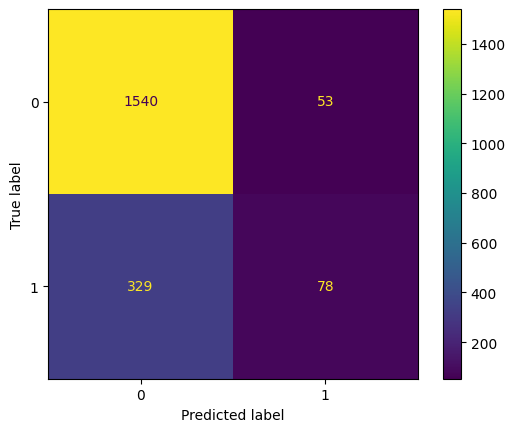

In [24]:
ConfusionMatrixDisplay.from_predictions(y_test, logistic.predict(X_test))
plt.show()

In [25]:
parameters = {
    'C': np.logspace(-3, 3, 7),
    'penalty':('l2','l1')
}
gridsearch_lr = GridSearchCV(LogisticRegression(solver='liblinear'),parameters, scoring="recall", cv=5)
gridsearch_lr.fit(X_train, y_train)

print("Logistic Regression Recall:", gridsearch_lr.best_score_)

Logistic Regression Recall: 0.23558282208588954


In [26]:
print(classification_report(y_test,logistic.predict(X_test)))

              precision    recall  f1-score   support

           0       0.82      0.97      0.89      1593
           1       0.60      0.19      0.29       407

    accuracy                           0.81      2000
   macro avg       0.71      0.58      0.59      2000
weighted avg       0.78      0.81      0.77      2000



**Random Forest**

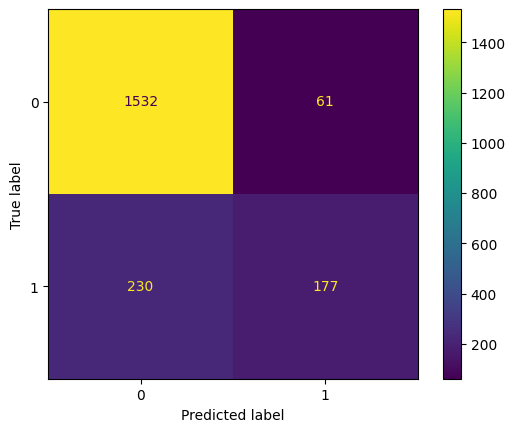

In [27]:
ConfusionMatrixDisplay.from_predictions(y_test, RF.predict(X_test))
plt.show()

In [28]:
print(classification_report(y_test,RF.predict(X_test)))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1593
           1       0.74      0.43      0.55       407

    accuracy                           0.85      2000
   macro avg       0.81      0.70      0.73      2000
weighted avg       0.84      0.85      0.84      2000



**SVM**

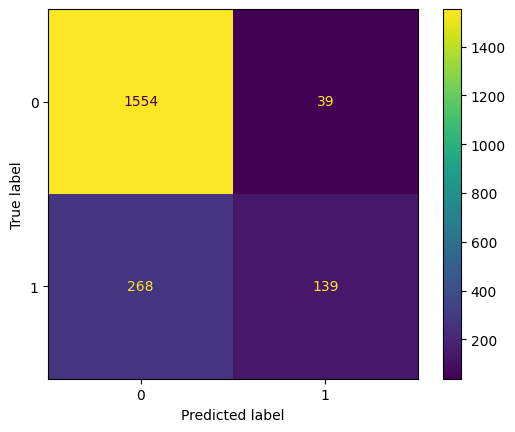

In [29]:
ConfusionMatrixDisplay.from_predictions(y_test, gridsearch_SVC.best_estimator_.predict(X_test))
plt.show()

In [30]:
print(classification_report(y_test,gridsearch_SVC.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      0.98      0.91      1593
           1       0.78      0.34      0.48       407

    accuracy                           0.85      2000
   macro avg       0.82      0.66      0.69      2000
weighted avg       0.84      0.85      0.82      2000



**ROC Curve**

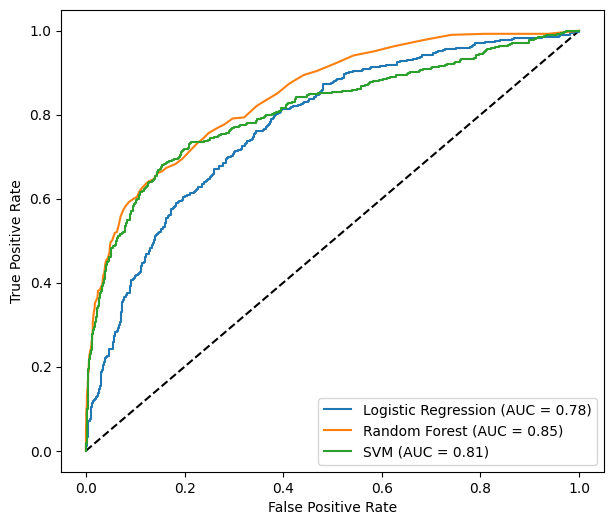

In [33]:
def plot_roc_curves(y_test, logistic, RF, gridsearch_SVC):
    plt.figure(figsize=(7, 6))

    # Logistic Regression
    y_pred_lr = logistic.predict_proba(X_test)[:, 1]
    fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)
    auc_lr = auc(fpr_lr, tpr_lr)

    # Random Forest
    y_pred_rf = RF.predict_proba(X_test)[:, 1]
    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
    auc_rf = auc(fpr_rf, tpr_rf)

    # SVC
    y_pred_svc = gridsearch_SVC.best_estimator_.predict_proba(X_test)[:, 1]
    fpr_svc, tpr_svc, _ = roc_curve(y_test, y_pred_svc)
    auc_svc = auc(fpr_svc, tpr_svc)

    # Plot ROC curves
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.2f})')
    plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
    plt.plot(fpr_svc, tpr_svc, label=f'SVM (AUC = {auc_svc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='best')

    plt.show()

plot_roc_curves(y_test, logistic, RF, gridsearch_SVC)

**Precision-Recall Curve**

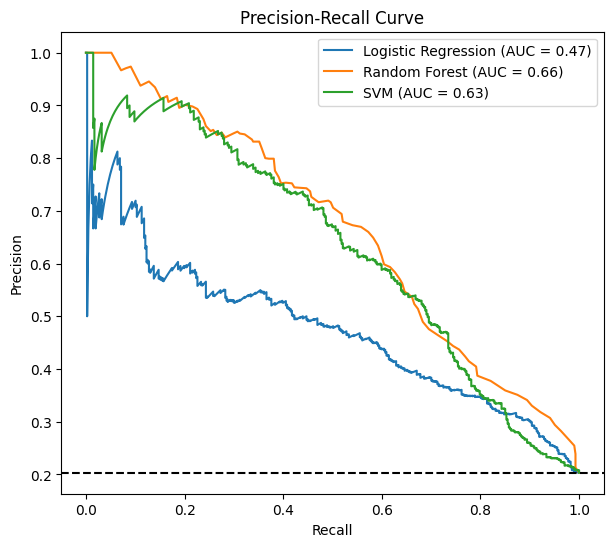

In [34]:
def plot_precision_recall_curves(y_test, logistic, RF, gridsearch_SVC):
    plt.figure(figsize=(7, 6))

    # Logistic Regression
    y_pred_lr = logistic.predict_proba(X_test)[:, 1]
    pre_lr, rec_lr, _ = precision_recall_curve(y_test, y_pred_lr)
    auc_lr = auc(rec_lr, pre_lr)

    # Random Forest
    y_pred_rf = RF.predict_proba(X_test)[:, 1]
    pre_rf, rec_rf, _ = precision_recall_curve(y_test, y_pred_rf)
    auc_rf = auc(rec_rf, pre_rf)

    # SVC
    y_pred_svc = gridsearch_SVC.best_estimator_.predict_proba(X_test)[:, 1]
    pre_svc, rec_svc, _ = precision_recall_curve(y_test, y_pred_svc)
    auc_svc = auc(rec_svc, pre_svc)

    # Plot Precision-Recall curves
    plt.plot(rec_lr, pre_lr, label=f'Logistic Regression (AUC = {auc_lr:.2f})')
    plt.plot(rec_rf, pre_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
    plt.plot(rec_svc, pre_svc, label=f'SVM (AUC = {auc_svc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')

    # Plot baseline
    neg = y_test.value_counts().iloc[0]
    pos = y_test.value_counts().iloc[1]
    plt.axhline(y=pos / (pos + neg), color='k', linestyle='--')

    # Finalize plot
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.show()

plot_precision_recall_curves(y_test, logistic, RF, gridsearch_SVC)

### **Conclusion**

From our modeling, the result shows that for this specific customer churn data, the Random Forest model has the best performance with the following metrics:
* Accuracy = 0.86
* Recall = 0.46
* ROC score = 0.85
* AUC score = 0.66

**Accuracy**:

An accuracy of 0.86 means that the model correctly predicts the status of 86% of the customers in the test set. In other words, the Random Forest model is able to accurately classify 86% of the customers as either churning or not churning. 

However, accuracy can be misleading when the class distribution is inbalanced, which is the case with customer churn data here. 

**Recall**:

A recall of 0.46 means that the Random Forest model correctly identifies 46% of the customers who are actually churning (True Positive Rate). In other words, the model is not able to detect a significant portion fo the customers who are likely to churn. This could be a concern for the bank, because they may miss out on opportunities to retain customers who are at risk of churning. However, this is the best we could do with the given data. 

**ROC**:

An ROC score of 0.84 means that the model has a good balance between true positive rate and false positive rate. This is important for predicting custoemr churn because it's crucial to correctly identify customers who are rasking of churning while minimizing the number of fasle positives, which can result in unnecessary retention actions and costs. 

**AUC**:

An AUC score of 0.65 indicates that the model has some discriminative ability to distinguish between churning and non-churning customers, but there is still a lot of room for improvement. 

**Feature Importance** using Random Forest model

In [35]:
importances = RF.feature_importances_

# Create a list of (feature, importance) tuples
feature_importances = [(feature, importance) for feature, importance in zip(X.columns, importances)]

# Sort the list by importance in descending order
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

# Print the sorted variable importance scores
for feature, importance in feature_importances:
    print(f"{feature}: {importance}")

Age: 0.1557221750903776
CreditScoreByAge: 0.13162683989269458
NumOfProducts: 0.12549409388953395
CreditScore: 0.09611779025953215
EstimatedSalary: 0.0899335257045188
Balance: 0.08990184766037702
TenureByAge: 0.07751952146344365
BalanceBySalary: 0.07070048672087764
Tenure: 0.04339794028880352
IsActiveMember: 0.04338945607067579
Geography_Germany: 0.021597872231602255
HasCrCard: 0.014493447177591297
Gender_Female: 0.010629213324635352
Geography_France: 0.010209025100606063
Gender_Male: 0.009996253517548504
Geography_Spain: 0.009270511607181744


From this sorted list of feature importance, we see that the top six most importance features for predicting customer churn are: 
* Age
* CreditScore by Age
* Number of Products
* Credit Score
* Estiamted Salary
* Balance